# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from config import Config
# import utils
import model as modellib, utils
import visualize
import yaml
from model import log
from PIL import Image

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class DrugDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n
 
    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.full_load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels
 
    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image, image_id):
        # print("draw_mask-->",image_id)
        # print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        # print("info-->",info)
        # print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    # print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    # print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask
 
    # 重新写load_shapes，里面包含自己的自己的类别
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "Pneumothorax")
 
        for i in range(count):
            # 获取图片宽和高
            print(i)
            filestr = imglist[i].split(".")[0]
            # print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            # print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
            # filestr = filestr.split("_")[1]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "labelme_json/" + filestr + "_json/info.yaml"
            print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            cv_img = cv2.imread(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
 
            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)
 
    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        print("image_id", image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img, image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
 
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("Pneumothorax") != -1:
                # print "car"
                labels_form.append("Pneumothorax")
          #  elif labels[i].find("leg") != -1:
                # print "leg"
            #    labels_form.append("leg")
          #  elif labels[i].find("well") != -1:
                # print "well"
           #     labels_form.append("well")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)
 
 
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [6]:
# 基础设置
dataset_root_path = "/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/"
img_floder = dataset_root_path + "pic"
mask_floder = dataset_root_path + "cv2_mask"
# yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)

# train與val數據集準備
dataset_train = DrugDataset()
dataset_train.load_shapes(count, img_floder, mask_floder, imglist, dataset_root_path)
dataset_train.prepare()

dataset_val = DrugDataset()
dataset_val.load_shapes(7, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val.prepare()  

0
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000504_json/img.png
1
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000549_json/img.png
2
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000575_json/img.png
3
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000569_json/img.png
4
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000566_json/img.png
5
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000531_json/img.png
6
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000526_json/img.png
7
/home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/datasets/train/labelme_json/cxrp_000523_json/img.png
8
/home/yang/rcnn/pulmon

image_id 9


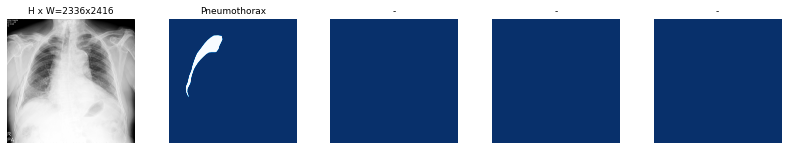

image_id 26


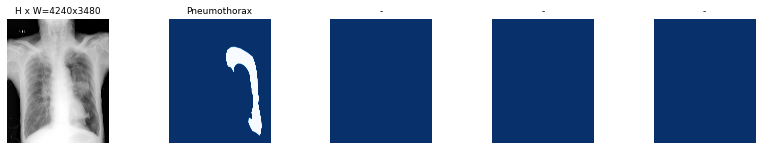

image_id 27


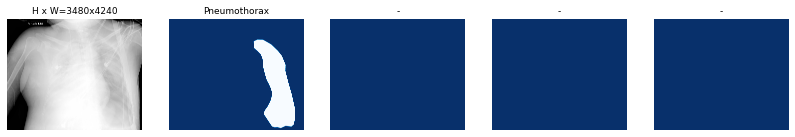

image_id 13


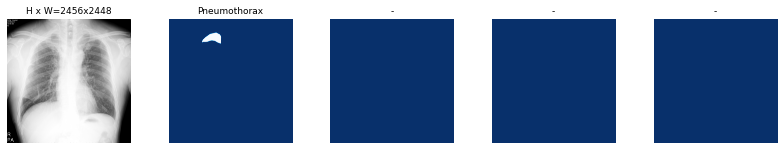

image_id 28


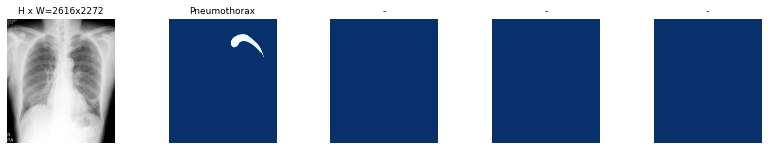

image_id 4


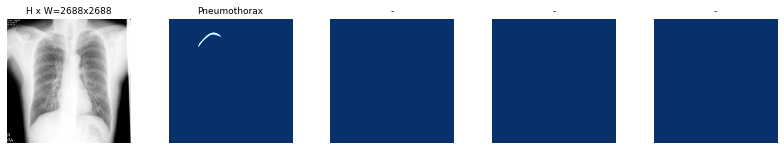

image_id 34


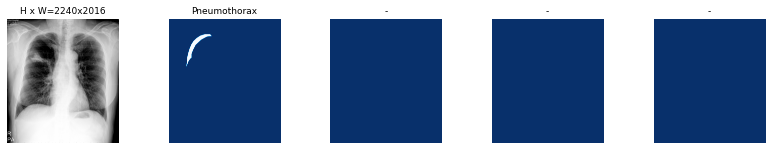

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/logs/shapes20220628T1336/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_

/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image_id 4
image_id 0
image_id 2
image_id 0


/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




image_idimage_id  14

image_id 33
Epoch 1/10
image_id 40
image_id 28
image_id 50
image_id 42


/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image_id 7
image_id 4
image_id 40
image_id 43
image_id 30
image_id 6


/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image_id 17
image_id 10
image_id 40
image_id 29
image_id 28
image_id 32


/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image_id 24
image_id 29
image_id 43


/home/yang/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image_id 42
image_id 8
image_id 20
image_id 32
image_id 35
image_id 2
image_id 31
image_id 19
image_id 30
image_id 12
image_id 38
image_id 19
image_id 37
image_id 8
  1/100 [..............................] - ETA: 2:56:29 - loss: 4.9061 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 2.2244 - mrcnn_class_loss: 0.6613 - mrcnn_bbox_loss: 1.1146 - mrcnn_mask_loss: 0.8701image_id 34
image_id 26
image_id 11
image_id 44
  2/100 [..............................] - ETA: 1:37:41 - loss: 4.7797 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 2.1749 - mrcnn_class_loss: 0.6321 - mrcnn_bbox_loss: 1.0734 - mrcnn_mask_loss: 0.8608image_id 2
image_id 41
image_id 13
  3/100 [..............................] - ETA: 1:11:12 - loss: 4.6432 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 2.1059 - mrcnn_class_loss: 0.5694 - mrcnn_bbox_loss: 1.0596 - mrcnn_mask_loss: 0.8695image_id 31
image_id 35
image_id 44
  4/100 [>.............................] - ETA: 57:55 - loss: 4.4012 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.9778 - mr

image_id 19
image_id 39
image_id 1
image_id 50
image_id 23
image_id 20
image_id 22
image_id 31
 30/100 [========>.....................] - ETA: 30:28 - loss: 2.5078 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.0015 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.6734 - mrcnn_mask_loss: 0.5664image_id 46
image_id 21
image_id 15
image_id 47
image_id 12
 31/100 [========>.....................] - ETA: 29:32 - loss: 2.4839 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.9898 - mrcnn_class_loss: 0.2284 - mrcnn_bbox_loss: 0.6702 - mrcnn_mask_loss: 0.5609image_id 35
image_id 30
image_id 16
 32/100 [========>.....................] - ETA: 28:41 - loss: 2.4634 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.9873 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.6620 - mrcnn_mask_loss: 0.5563image_id 9
image_id 4
image_id 21
image_id 38
image_id 21
image_id 39
image_id 38
image_id 45
image_id 25
image_id 5
image_id 34
image_id 26
image_id 15
image_id 37
image_id 3
image_id 48
image_id 2
image_id 29
image_id 4

 57/100 [================>.............] - ETA: 18:49 - loss: 2.0254 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.7891 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 0.5489 - mrcnn_mask_loss: 0.4851image_id 8
image_id 44
image_id 19
 58/100 [================>.............] - ETA: 18:13 - loss: 2.0170 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.7860 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.5450 - mrcnn_mask_loss: 0.4846image_id 17
image_id 41
image_id 2
 59/100 [================>.............] - ETA: 17:37 - loss: 2.0089 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.7839 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.5418 - mrcnn_mask_loss: 0.4838image_id 42
image_id 30
 60/100 [=================>............] - ETA: 17:03 - loss: 1.9972 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.7787 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.5384 - mrcnn_mask_loss: 0.4819image_id 24
image_id 1
image_id 48
image_id 1
image_id 11
image_id 47
image_id 16
image_id 26
image_id 22
image_id 28
imag

 85/100 [========================>.....] - ETA: 6:20 - loss: 1.7964 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.7070 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4416image_id 40
image_id 1
image_id 45
 86/100 [========================>.....] - ETA: 5:53 - loss: 1.7921 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.7057 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4398image_id 42
image_id 17
 87/100 [=========================>....] - ETA: 5:25 - loss: 1.7824 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.7011 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4384image_id 8
image_id 5
image_id 19
image_id 29
image_id 17
image_id 37
image_id 7
image_id 39
image_id 27
image_id 28
image_id 15
image_id 2
image_id 29
image_id 27
 88/100 [=========================>....] - ETA: 5:04 - loss: 1.7776 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6996 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4

 12/100 [==>...........................] - ETA: 29:53 - loss: 1.1165 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.3580 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.3530image_id 11
image_id 40
image_id 9
image_id 49
image_id 40
image_id 4
image_id 5
image_id 39
image_id 26
image_id 10
image_id 50
image_id 36
image_id 6
image_id 27
image_id 27
 13/100 [==>...........................] - ETA: 32:04 - loss: 1.1039 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.3555 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.3478image_id 47
image_id 11
image_id 50
 14/100 [===>..........................] - ETA: 31:23 - loss: 1.1061 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3514 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.3538image_id 21
image_id 3
image_id 23
image_id 13
image_id 35
image_id 16
 16/100 [===>..........................] - ETA: 29:02 - loss: 1.1226 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.3790 - mrcnn_cla

 40/100 [===========>..................] - ETA: 23:20 - loss: 1.1037 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.2650 - mrcnn_mask_loss: 0.3468image_id 20
image_id 21
image_id 44
image_id 5
image_id 26
image_id 31
image_id 23
image_id 0
image_id 12
image_id 15
image_id 17
image_id 47
image_id 22
image_id 0
image_id 34
image_id 23
image_id 32
image_id 31
image_id 9
 41/100 [===========>..................] - ETA: 23:49 - loss: 1.1000 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.2644 - mrcnn_mask_loss: 0.3453image_id 44
image_id 40
image_id 23
image_id 10
image_id 42
 43/100 [===========>..................] - ETA: 22:29 - loss: 1.0927 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4058 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2629 - mrcnn_mask_loss: 0.3446image_id 39
image_id 47
image_id 48
image_id 34
image_id 27
image_id 5
image_id 1
image_id 49
 44/100 [============>............

 68/100 [===================>..........] - ETA: 12:47 - loss: 1.0646 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.3402image_id 6
image_id 2
image_id 12
image_id 11
image_id 35
image_id 45
image_id 33
image_id 50
image_id 1
image_id 32
image_id 10
 69/100 [===================>..........] - ETA: 12:31 - loss: 1.0585 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.3384image_id 22
image_id 32
image_id 39
image_id 23
image_id 17
image_id 48
image_id 38
image_id 24
image_id 20
image_id 27
image_id 0
 70/100 [====================>.........] - ETA: 12:11 - loss: 1.0574 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 0.3392image_id 15
image_id 29
image_id 19
image_id 18
image_id 10
image_id 31
image_id 36
image_id 3
image_id 44
 71/100 [====================>.........] - ET

 96/100 [===========================>..] - ETA: 1:36 - loss: 1.0124 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.3373image_id 22
image_id 50
image_id 42
image_id 17
image_id 32
image_id 9
image_id 49
image_id 17
image_id 35
image_id 1
image_id 15
image_id 42
image_id 27
image_id 28
image_id 16
 97/100 [============================>.] - ETA: 1:13 - loss: 1.0111 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.3764 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.3366image_id 26
image_id 3
image_id 21
image_id 38
image_id 6
 98/100 [============================>.] - ETA: 48s - loss: 1.0106 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.3750 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.3373 image_id 42
image_id 12
image_id 31
image_id 43
image_id 31
image_id 29
 99/100 [============================>.] - ETA: 24s - loss: 1.0085 - rpn_class_loss: 0.0172 - rpn_bbox_loss

 23/100 [=====>........................] - ETA: 32:46 - loss: 0.8394 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.1916 - mrcnn_mask_loss: 0.2977image_id 27
image_id 28
image_id 25
 24/100 [======>.......................] - ETA: 31:39 - loss: 0.8474 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.2843 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.3010image_id 1
image_id 23
image_id 5
image_id 10
image_id 43
image_id 41
image_id 40
image_id 42
image_id 37
image_id 34
 25/100 [======>.......................] - ETA: 31:33 - loss: 0.8390 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.1874 - mrcnn_mask_loss: 0.3010image_id 14
image_id 5
image_id 36
image_id 48
image_id 38
image_id 50
image_id 35
image_id 33
image_id 22
image_id 30
image_id 19
image_id 50
 26/100 [======>.......................] - ETA: 31:18 - loss: 0.8465 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.28

 51/100 [==============>...............] - ETA: 20:26 - loss: 0.8262 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2874 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2945image_id 26
image_id 47
 52/100 [==============>...............] - ETA: 19:49 - loss: 0.8240 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2856 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.2949image_id 12
image_id 0
image_id 2
image_id 44
image_id 50
image_id 39
image_id 36
image_id 19
image_id 21
image_id 14
image_id 50
image_id 35
image_id 14
image_id 0
image_id 39
image_id 13
image_id 27
 53/100 [==============>...............] - ETA: 19:45 - loss: 0.8228 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2849 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.2953image_id 0
image_id 16
image_id 32
 54/100 [===============>..............] - ETA: 19:11 - loss: 0.8212 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2856 - mrcnn_class_loss: 0.0561 - mrcnn

 79/100 [======================>.......] - ETA: 8:41 - loss: 0.8128 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2757 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2937image_id 10
image_id 16
image_id 35
image_id 29
image_id 41
image_id 41
image_id 17
image_id 25
 80/100 [=======================>......] - ETA: 8:17 - loss: 0.8097 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.2932image_id 37
image_id 4
image_id 38
image_id 17
image_id 7
image_id 45
image_id 38
 81/100 [=======================>......] - ETA: 7:51 - loss: 0.8077 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.2933image_id 46
image_id 30
image_id 16
image_id 23
image_id 39
image_id 27
image_id 2
image_id 24
image_id 20
image_id 21
image_id 48
image_id 45
image_id 36
image_id 27
image_id 29
 83/100 [=======================>......] - ETA: 7:03 - los

  6/100 [>.............................] - ETA: 33:07 - loss: 0.6962 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2555image_id 48
image_id 10
image_id 10
image_id 34
image_id 9
image_id 30
image_id 20
image_id 9
image_id 1
image_id 38
image_id 25
  7/100 [=>............................] - ETA: 33:44 - loss: 0.7043 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2325 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2566image_id 45
image_id 19
image_idimage_id 18
 32
image_id 17
  8/100 [=>............................] - ETA: 32:48 - loss: 0.7227 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2518 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2618image_id 26
image_id 17
image_id 34
image_id 24
image_id 6
image_id 41
image_id 44
image_id 11
image_id 40
image_id 4
  9/100 [=>............................] - ETA: 34:05 - loss: 0.7303 - rpn_class_loss: 0.0134 - rpn_bbox_

 34/100 [=========>....................] - ETA: 26:51 - loss: 0.7185 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2644image_id 16
image_id 27
image_id 2
image_id 35
 35/100 [=========>....................] - ETA: 26:04 - loss: 0.7156 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2646image_id 23
image_id 11
image_id 35
image_id 47
image_id 27
image_id 42
image_id 46
image_id 42
image_id 28
image_id 19
 36/100 [=========>....................] - ETA: 26:13 - loss: 0.7170 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2652image_id 48
image_id 30
image_id 40
 37/100 [==========>...................] - ETA: 25:28 - loss: 0.7116 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2645image_id 0
im

 62/100 [=================>............] - ETA: 15:36 - loss: 0.6855 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2626image_id 29
image_id 38
image_id 15
image_id 45
 63/100 [=================>............] - ETA: 15:04 - loss: 0.6858 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2627image_id 41
image_id 22
image_id 37
image_id 46
image_id 31
image_id 34
image_id 35
image_id 40
image_id 24
 64/100 [==================>...........] - ETA: 14:43 - loss: 0.6855 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2622image_id 29
image_id 15
image_id 26
image_id 30
image_id 25
image_id 42
image_id 50
image_id 36
image_id 9
image_id 7
image_id 47
 65/100 [==================>...........] - ETA: 14:22 - loss: 0.6835 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2091 - mrcnn_

 90/100 [==========================>...] - ETA: 4:04 - loss: 0.6667 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.2593image_id 47
image_id 17
image_id 39
image_id 8
image_id 35
image_id 43
image_id 30
image_id 23
image_id 16
image_id 10
image_id 41
 91/100 [==========================>...] - ETA: 3:41 - loss: 0.6660 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.2589image_id 16
image_id 4
image_id 43
image_id 15
 92/100 [==========================>...] - ETA: 3:15 - loss: 0.6646 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.2587image_id 49
image_id 25
image_id 40
image_id 21
image_id 48
image_id 17
image_id 50
image_id 39
image_id 7
image_id 9
image_id 14
image_id 33
image_id 47
image_id 49
image_id 37
image_id 1
image_id 5
image_id 29
 93/100 [================

 18/100 [====>.........................] - ETA: 36:38 - loss: 0.5382 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.2293image_id 19
image_id 16
image_id 7
image_id 43
image_id 25
image_id 21
image_id 29
image_id 8
image_id 50
image_id 7
image_id 29
image_id 9
image_id 47
image_id 31
image_id 2
image_id 45
 19/100 [====>.........................] - ETA: 37:36 - loss: 0.5358 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1495 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2270image_id 37
image_id 6
image_id 7
image_id 1
image_id 31
 20/100 [=====>........................] - ETA: 36:20 - loss: 0.5381 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1508 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2270image_id 22
image_id 31
image_id 13
image_id 39
image_id 17
image_id 30
image_id 3
image_id 18
image_id 50
 21/100 [=====>........................] - ETA: 35:57 - loss:

 45/100 [============>.................] - ETA: 23:12 - loss: 0.5231 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.2181image_id 1
image_id 31
image_id 27
image_id 31
image_id 40
image_id 14
image_id 20
image_id 43
image_id 3
image_id 10
image_id 32
 46/100 [============>.................] - ETA: 23:02 - loss: 0.5212 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.2184image_id 19
image_id 28
image_id 28
image_id 9
image_id 16
image_id 4
image_id 24
image_id 3
 47/100 [=============>................] - ETA: 22:34 - loss: 0.5217 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.2183image_id 16
image_id 27
image_id 35
image_id 30
image_id 38
 48/100 [=============>................] - ETA: 21:56 - loss: 0.5196 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1402 - mrcnn_cla

 73/100 [====================>.........] - ETA: 11:22 - loss: 0.5096 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.2099image_id 30
image_id 30
image_id 12
image_id 4
image_id 29
image_id 15
image_id 3
image_id 19
image_id 6
image_id 34
image_id 42
image_id 46
image_id 11
image_id 5
image_id 44
 74/100 [=====================>........] - ETA: 11:01 - loss: 0.5081 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.2099image_id 49
image_id 16
image_id 25
image_id 49
 75/100 [=====================>........] - ETA: 10:32 - loss: 0.5101 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.2098image_id 28
image_id 42
image_id 37
image_id 37
image_id 9
image_id 38
image_id 12
 76/100 [=====================>........] - ETA: 10:04 - loss: 0.5098 - rpn_class_loss: 0.0128 - rpn_bbox_

image_id 9
image_id 5
image_id 35
image_id 42
image_id 18
image_id 26
image_id 12
image_id 16
image_id 28
image_id 33
image_id 11
image_id 42
image_id 14
image_id 26
  1/100 [..............................] - ETA: 1:08:08 - loss: 0.5664 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2349image_id 4
image_id 15
image_id 23
image_id 23
image_id 3
image_id 6
image_id 37
image_id 19
image_id 15
image_id 27
image_id 0
image_id 11
  3/100 [..............................] - ETA: 49:23 - loss: 0.4970 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2071  image_id 3
image_id 49
image_id 27
image_id 31
image_id 39
image_id 39
  4/100 [>.............................] - ETA: 41:44 - loss: 0.4608 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2027image_id 3
image_id 7
image_id 

 28/100 [=======>......................] - ETA: 29:49 - loss: 0.4262 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1849image_id 38
image_id 29
image_id 23
image_id 33
image_id 16
image_id 31
 29/100 [=======>......................] - ETA: 29:15 - loss: 0.4333 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1862image_id 42
image_id 18
image_id 20
image_id 30
image_id 8
image_id 25
image_id 47
image_id 19
image_id 17
image_id 31
 30/100 [========>.....................] - ETA: 28:59 - loss: 0.4338 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1862image_id 2
image_id 17
image_id 37
image_id 33
image_id 28
image_id 37
image_id 6
image_id 41
image_id 34
image_id 11
image_id 1
image_id 45
 31/100 [========>.....................] - ETA: 29:03 - loss: 0.4345 - rpn_class

 56/100 [===============>..............] - ETA: 18:27 - loss: 0.4288 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1851image_id 25
image_id 42
image_id 50
image_id 37
image_id 41
image_id 15
 57/100 [================>.............] - ETA: 17:58 - loss: 0.4285 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1849image_id 23
image_id 4
image_id 31
image_id 10
image_id 25
 58/100 [================>.............] - ETA: 17:25 - loss: 0.4292 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1847image_id 22
image_id 36
image_id 26
image_id 7
image_id 5
image_id 49
image_id 39
image_id 15
image_id 44
image_id 15
image_id 30
image_id 38
image_id 35
image_id 44
image_id 33
 59/100 [================>.............] - ETA: 17:10 - loss: 0.4287 - rpn_class_loss: 0.0118 - rpn_bbo

image_id 7
 85/100 [========================>.....] - ETA: 6:12 - loss: 0.4191 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1801image_id 25
image_id 6
image_id 38
image_id 11
image_id 14
image_id 1
 86/100 [========================>.....] - ETA: 5:46 - loss: 0.4185 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1801image_id 32
image_id 37
image_id 10
image_id 22
image_id 20
image_id 25
image_id 31
image_id 28
image_id 43
image_id 35
image_id 23
 87/100 [=========================>....] - ETA: 5:22 - loss: 0.4182 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1799image_id 33
image_id 26
 88/100 [=========================>....] - ETA: 4:55 - loss: 0.4174 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0860 - mrcnn_

image_id 35
image_id 50
image_id 6
image_id 14
image_id 44
image_id 16
image_id 20
image_id 27
image_id 36
image_id 16
image_id 20
image_id 41
 13/100 [==>...........................] - ETA: 36:10 - loss: 0.3998 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1762image_id 23
image_id 33
image_id 8
image_id 26
 14/100 [===>..........................] - ETA: 34:29 - loss: 0.4001 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1745image_id 37
image_id 22
image_id 24
image_id 10
image_id 28
image_id 19
image_id 21
image_id 23
 15/100 [===>..........................] - ETA: 35:10 - loss: 0.4075 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1745image_id 11
image_id 34
image_id 48
image_id 30
image_id 42
 16/100 [===>..........................] - ETA: 33:54 - loss: 0.40

image_id 38
image_id 30
image_id 20
image_id 42
image_id 37
image_id 17
image_id 1
image_id 4
image_id 26
 41/100 [===========>..................] - ETA: 24:49 - loss: 0.3674 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1692image_id 32
image_id 20
image_id 37
image_id 33
image_id 6
 42/100 [===========>..................] - ETA: 24:10 - loss: 0.3703 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1693image_id 42
image_id 36
image_id 40
image_id 21
image_id 0
image_id 28
image_id 4
 43/100 [===========>..................] - ETA: 23:39 - loss: 0.3720 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1686image_id 27
image_id 44
image_id 32
image_id 33
 44/100 [============>.................] - ETA: 22:58 - loss: 0.3699 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0765

image_id 10
image_id 46
 69/100 [===================>..........] - ETA: 12:45 - loss: 0.3638 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1687image_id 17
image_id 13
image_id 48
image_id 25
 70/100 [====================>.........] - ETA: 12:16 - loss: 0.3631 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1685image_id 11
image_id 32
image_id 3
image_id 8
image_id 31
image_id 10
image_id 16
image_id 18
image_id 28
 71/100 [====================>.........] - ETA: 11:52 - loss: 0.3627 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1683image_id 15
image_id 22
image_id 19
image_id 21
image_id 14
image_id 1
image_id 16
image_id 35
image_id 43
image_id 17
image_id 45
image_id 32
image_id 11
 72/100 [====================>.........] - ETA: 11:34 - loss: 0.3620 - rpn_clas

 97/100 [============================>.] - ETA: 1:14 - loss: 0.3586 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1646image_id 50
image_id 32
image_id 27
image_id 33
image_id 20
 98/100 [============================>.] - ETA: 49s - loss: 0.3581 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1645 image_id 29
image_id 19
image_id 47
image_id 8
image_id 45
image_id 0
 99/100 [============================>.] - ETA: 24s - loss: 0.3577 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1645image_id 34
image_id 41
image_id 27
image_id 40
image_id 1
image_id 7
image_id 34
100/100 [==============================] - 2486s 25s/step - loss: 0.3567 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1641 - v

image_id 4
image_id 27
image_id 30
image_id 9
 25/100 [======>.......................] - ETA: 30:34 - loss: 0.3281 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1575image_id 35
image_id 3
image_id 27
image_id 14
image_id 34
image_id 31
image_id 13
image_id 32
image_id 48
image_id 9
image_id 6
image_id 7
image_id 39
image_id 50
image_id 28
image_id 36
image_id 50
 26/100 [======>.......................] - ETA: 31:05 - loss: 0.3244 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1568image_id 0
image_id 12
image_id 15
image_id 28
image_id 12
 27/100 [=======>......................] - ETA: 30:18 - loss: 0.3241 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1580image_id 8
image_id 49
image_id 35
 28/100 [=======>......................] - ETA: 29:22 - loss: 0.3286 - r

 53/100 [==============>...............] - ETA: 19:36 - loss: 0.3259 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1551image_id 36
image_id 1
image_id 32
image_id 36
image_id 19
image_id 43
image_id 34
image_id 40
image_id 26
 54/100 [===============>..............] - ETA: 19:14 - loss: 0.3291 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1550image_id 4
image_id 33
image_id 14
image_id 38
image_id 1
image_id 10
image_id 4
image_id 42
image_id 8
image_id 37
image_id 4
image_id 30
image_id 16
image_id 11
image_id 36
 55/100 [===============>..............] - ETA: 19:05 - loss: 0.3293 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1549image_id 44
image_id 19
image_id 28
image_id 11
image_id 47
 56/100 [===============>..............] - ETA: 18:30 - loss: 0.3310 -

image_id 39
image_id 27
image_id 37
image_id 9
image_id 36
image_id 19
image_id 50
image_id 41
 82/100 [=======================>......] - ETA: 7:36 - loss: 0.3212 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1508image_id 24
image_id 36
image_id 5
image_id 40
image_id 28
image_id 18
image_id 38
image_id 32
 83/100 [=======================>......] - ETA: 7:10 - loss: 0.3229 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1509image_id 0
image_id 44
image_id 9
image_id 35
image_id 16
image_id 33
 84/100 [========================>.....] - ETA: 6:43 - loss: 0.3243 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1508image_id 44
image_id 4
image_id 7
image_id 25
image_id 13
image_id 35
image_id 32
 85/100 [========================>.....] - ETA: 6:17 - loss: 0.3237 - rpn

  9/100 [=>............................] - ETA: 39:25 - loss: 0.2637 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1340image_id 25
image_id 19
image_id 38
image_id 37
image_id 31
image_id 11
image_id 26
image_id 3
image_id 12
image_id 46
image_id 8
image_id 22
image_id 21
 10/100 [==>...........................] - ETA: 42:01 - loss: 0.2643 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1343image_id 10
image_id 46
image_id 9
image_id 17
image_id 11
image_id 10
image_id 37
image_id 47
image_id 43
 11/100 [==>...........................] - ETA: 40:56 - loss: 0.2679 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1352image_id 37
image_id 40
image_id 46
image_id 36
image_id 14
image_id 8
 12/100 [==>...........................] - ETA: 39:19 - loss: 0.2674 - rpn_class

 37/100 [==========>...................] - ETA: 26:30 - loss: 0.2797 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1341image_id 14
image_id 20
image_id 2
image_id 34
image_id 46
image_id 2
image_id 24
image_id 37
image_id 16
image_id 40
image_id 42
image_id 10
image_id 50
image_id 40
image_id 6
image_id 29
 38/100 [==========>...................] - ETA: 26:32 - loss: 0.2795 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1344image_id 23
image_id 28
 39/100 [==========>...................] - ETA: 25:48 - loss: 0.2789 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1344image_id 36
image_id 32
image_id 19
image_id 41
image_id 8
image_id 39
 40/100 [===========>..................] - ETA: 25:15 - loss: 0.2795 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0437 - mrcnn_cl

 65/100 [==================>...........] - ETA: 14:39 - loss: 0.2897 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1345image_id 23
image_id 39
image_id 41
image_id 37
image_id 49
image_id 3
image_id 0
image_id 15
image_id 43
image_id 22
image_id 50
image_id 8
image_id 17
image_id 13
image_id 30
image_id 30
image_id 4
image_id 42
 66/100 [==================>...........] - ETA: 14:27 - loss: 0.2899 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1351image_id 50
image_id 27
image_id 33
image_id 23
 67/100 [===================>..........] - ETA: 13:56 - loss: 0.2903 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1355image_id 48
image_id 36
image_id 38
 68/100 [===================>..........] - ETA: 13:26 - loss: 0.2896 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.047

 93/100 [==========================>...] - ETA: 2:54 - loss: 0.2860 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1338image_id 7
image_id 6
image_id 22
image_id 47
image_id 2
image_id 15
image_id 27
image_id 31
image_id 44
image_id 24
image_id 20
image_id 21
image_id 39
image_id 7
image_id 11
image_id 20
image_id 35
image_id 23
image_id 47
image_id 6
image_id 14
image_id 17
 94/100 [===========================>..] - ETA: 2:32 - loss: 0.2854 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1338image_id 9
image_id 2
image_id 43
 95/100 [===========================>..] - ETA: 2:06 - loss: 0.2849 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1336image_id 29
image_id 9
 96/100 [===========================>..] - ETA: 1:40 - loss: 0.2844 - rpn_class_loss: 0.0101 - rpn_

 20/100 [=====>........................] - ETA: 33:18 - loss: 0.2693 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1266image_id 11
image_id 44
image_id 17
image_id 1
 21/100 [=====>........................] - ETA: 32:08 - loss: 0.2686 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1273image_id 0
image_id 24
image_id 15
image_id 15
image_id 27
image_id 28
image_id 48
image_id 27
image_id 8
image_id 29
image_id 33
image_id 17
image_id 47
image_id 33
image_id 31
image_id 19
image_id 36
image_id 23
image_id 13
image_id 32
image_id 31
 22/100 [=====>........................] - ETA: 34:18 - loss: 0.2665 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1272image_id 0
image_id 38
image_id 13
 23/100 [=====>........................] - ETA: 33:06 - loss: 0.2630 - rpn_class

 48/100 [=============>................] - ETA: 21:32 - loss: 0.2742 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1255image_id 42
image_id 10
image_id 40
image_id 6
image_id 17
image_id 45
image_id 28
image_id 10
image_id 8
image_id 11
 49/100 [=============>................] - ETA: 21:13 - loss: 0.2764 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1252image_id 36
image_id 48
image_id 0
image_id 44
image_id 13
image_id 50
image_id 3
image_id 50
image_id 25
image_id 1
image_id 42
image_id 12
image_id 49
image_id 49
 50/100 [==============>...............] - ETA: 21:02 - loss: 0.2763 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1250image_id 12
image_id 6
image_id 3
 51/100 [==============>...............] - ETA: 20:25 - loss: 0.2761 - rpn_class_loss: 0.0099 -

image_id 39
 76/100 [=====================>........] - ETA: 10:03 - loss: 0.2796 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1244image_id 8
image_id 44
image_id 49
 77/100 [======================>.......] - ETA: 9:34 - loss: 0.2788 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1244 image_id 25
image_id 29
image_id 35
image_id 4
image_id 17
image_id 24
image_id 4
image_id 30
 78/100 [======================>.......] - ETA: 9:09 - loss: 0.2783 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1243image_id 18
image_id 36
image_id 25
image_id 6
image_id 39
image_id 9
image_id 35
image_id 6
image_id 0
image_id 39
image_id 50
image_id 29
image_id 38
image_id 12
image_id 37
 79/100 [======================>.......] - ETA: 8:47 - loss: 0.2783 - rpn_class_loss: 0.0099 - r

In [84]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

AssertionError: Create model in training mode.

In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [13]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode 
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Loading weights from  /home/yang/rcnn/pulmonary-nodules-MaskRCNN/Mask-RCNN-Git/Mask-RCNN/logs/shapes20220628T1336/mask_rcnn_shapes_0010.h5


image_id 1
original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 3408.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:   23.00000  max:  106.00000
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000


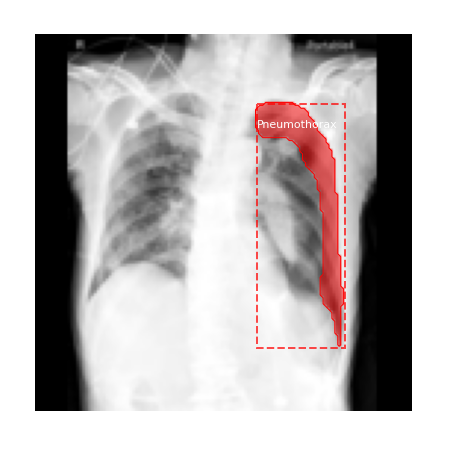

In [91]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
#image = skimage.io.imread("./test/cxrp_000027.jpg")
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  128.00000


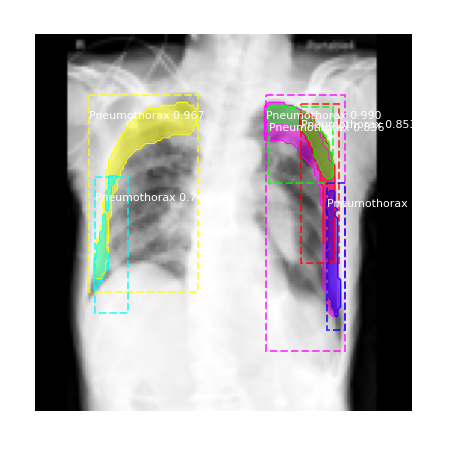

In [95]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [81]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

image_id 1
image_id 5
image_id 6
image_id 0
image_id 6
image_id 6
image_id 2
image_id 4
image_id 6
image_id 2
mAP:  1.0
